# Image segmentation and neural network quantization

Here are all the import statements needed for all the exercises

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
import tensorflow.lite

Loading the Sentinel 2 dataset. Images and labels are padded to be 256x256 in size and normalized by their maximum value. 40 images are used for the train partition (X_train, Y_train) and 10 for testing (X_test, Y_test)

In [2]:
loaded = np.load('sentinel2.npz')
X = loaded['X'].astype(np.float32)
Y = loaded['Y'].astype(np.float32)
X = np.pad(X, ((0, 0), (3, 3), (3, 3), (0, 0)))
Y = np.pad(Y, ((0, 0), (3, 3), (3, 3), (0, 0)))
X_train = X[:40] / np.max(X[:40])
X_test = X[40:] / np.max(X[:40])
Y_train = Y[:40]
Y_test = Y[40:]

**[TODO]** Implement the U-net neural network for segmentation as drawn in the lab document.

In [41]:
def conv_layer(features, stride, kernel_size=5, k_regularizer=tf.keras.regularizers.l2(0.001)):
    return tf.keras.layers.Conv2D(features,
                                  kernel_size=kernel_size,
                                  strides=(stride, stride),
                                  padding='same',
                                  # kernel_regularizer=k_regularizer
                                  )


def post_layer(inputs):
    h = tf.keras.layers.BatchNormalization()(inputs)
    return tf.keras.layers.Activation('relu')(h)

In [42]:
N = 2
use_dropout = False
dropout_percent = 0.5
# Clearing previous model
tf.keras.backend.clear_session()
# Inputs
inputs = tf.keras.layers.Input(shape=(256, 256, 12))
# Building h10
h1 = conv_layer(32, 1)(inputs)
if use_dropout:
    h1 = tf.keras.layers.Dropout(dropout_percent)(h1)
h1 = post_layer(h1)
h1 = conv_layer(32, 1)(h1)
if use_dropout:
    h1 = tf.keras.layers.Dropout(dropout_percent)(h1)
h10 = post_layer(h1)
# Building h20
h2 = conv_layer(64, 2)(h10)
if use_dropout:
    h2 = tf.keras.layers.Dropout(dropout_percent)(h2)
h20 = post_layer(h2)
# Building h30
h3 = conv_layer(128, 2)(h20)
if use_dropout:
    h3 = tf.keras.layers.Dropout(dropout_percent)(h3)
h3 = post_layer(h3)
h3 = conv_layer(128, 1)(h3)
if use_dropout:
    h3 = tf.keras.layers.Dropout(dropout_percent)(h3)
h3 = post_layer(h3)
h30 = tf.keras.layers.UpSampling2D()(h3)
# Building h21
h2 = tf.keras.layers.Concatenate()([h20, h30])
h2 = conv_layer(64, 1)(h2)
if use_dropout:
    h2 = tf.keras.layers.Dropout(dropout_percent)(h2)
h2 = post_layer(h2)
h21 = tf.keras.layers.UpSampling2D()(h2)
# Building h11
h1 = tf.keras.layers.Concatenate()([h10, h21])
h1 = conv_layer(32, 1)(h1)
if use_dropout:
    h1 = tf.keras.layers.Dropout(dropout_percent)(h1)
h11 = post_layer(h1)
# Classification
outputs = tf.keras.layers.Conv2D(N,
                                 kernel_size=1,
                                 padding='same',
                                 activation='softmax',
                                  # kernel_regularizer=tf.keras.regularizers.l2(0.001)
                                 )(h11)
print(f'Shape of the output: {outputs.shape[1:]}')

Shape of the output: (256, 256, 2)


**[TODO]** Compile and train the model (might take some time...)

In [3]:
# Compiling
if tf.io.gfile.exists('./models/cultivated_recognition'):
    model = tf.keras.models.load_model('./models/cultivated_recognition')
    print('Model loaded!')
else:
    model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model loaded!


In [45]:
# Training
model.fit(X_train, Y_train, batch_size=8, epochs=50, validation_data=(X_test, Y_test))

Epoch 1/50
5/5 [==============================] - 2s 318ms/step - loss: 0.3967 - accuracy: 0.8329 - val_loss: 37.4655 - val_accuracy: 0.7827
Epoch 2/50
5/5 [==============================] - 2s 312ms/step - loss: 0.3932 - accuracy: 0.8288 - val_loss: 22.1642 - val_accuracy: 0.7827
Epoch 3/50
5/5 [==============================] - 2s 312ms/step - loss: 0.3767 - accuracy: 0.8362 - val_loss: 12.7905 - val_accuracy: 0.7827
Epoch 4/50
5/5 [==============================] - 2s 313ms/step - loss: 0.3739 - accuracy: 0.8363 - val_loss: 6.1226 - val_accuracy: 0.7827
Epoch 5/50
5/5 [==============================] - 2s 312ms/step - loss: 0.3636 - accuracy: 0.8423 - val_loss: 3.1262 - val_accuracy: 0.7827
Epoch 6/50
5/5 [==============================] - 2s 313ms/step - loss: 0.3682 - accuracy: 0.8356 - val_loss: 1.6313 - val_accuracy: 0.7824
Epoch 7/50
5/5 [==============================] - 2s 312ms/step - loss: 0.3536 - accuracy: 0.8389 - val_loss: 0.5096 - val_accuracy: 0.8090
Epoch 8/50
5/5 [=

**[TODO]** Test the model on the test set and measure the accuracy.

In [4]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 5s 5s/step - loss: 0.2798 - accuracy: 0.8807


[0.27983927726745605, 0.880664050579071]

In [5]:
test_pred = np.argmax(model.predict(X_test), axis=-1)
# print(np.unique(test_pred, return_counts=True))

1/1 [==============================] - 0s 184ms/step


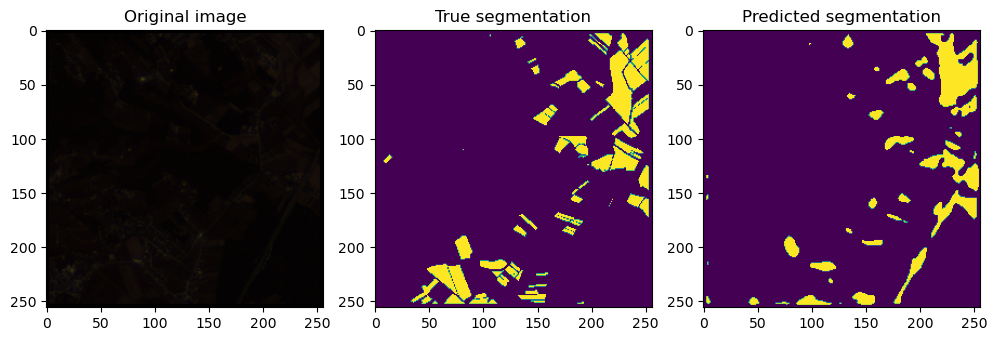

In [6]:
# Comparing the results
img_index = 0
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title('Original image')
plt.imshow(X_test[img_index, :, :, 2::-1])
plt.subplot(1, 3, 2)
plt.title('True segmentation')
plt.imshow(Y_test[img_index, :, :])
plt.subplot(1, 3, 3)
plt.title('Predicted segmentation')
plt.imshow(test_pred[img_index, :, :])
plt.tight_layout()
plt.show()

In [56]:
# Saving the model
model.save('./models/cultivated_recognition')

INFO:tensorflow:Assets written to: ./models/cultivated_recognition\assets


INFO:tensorflow:Assets written to: ./models/cultivated_recognition\assets


**[TODO]** Convert model to TFLite with 8-bit weight quantization 

In [7]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/cultivated_recognition')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converted_model = converter.convert()
with open('./tfl_cultivated_recognition.tflite', 'wb') as f:
    f.write(converted_model)

**[TODO]** Test the accuracy of the quantized model by writing your own "evaluate" function. Remember that TFLite interpreter can only process one sample at a time, not a batch.

In [38]:
def tflite_evaluate(interpreter, images_data, images_labels):
    N = images_data.shape[0]
    Npx = images_data.shape[1] * images_data.shape[2]
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    mse = []
    accuracy = 0
    for i in range(N):
        # Obtaining single data from input dataset
        test_data = images_data[i:(i + 1)]
        test_label = images_labels[i:(i + 1)]
        # Feeding data into the input tensor
        interpreter.set_tensor(input_index, test_data)
        # Running the model
        interpreter.invoke()
        out_tensor = interpreter.get_tensor(output_index)
        prediction_oh = out_tensor[:, :, :, 1:2]
        prediction = np.argmax(out_tensor, axis=-1)
        # Computing MSE of i-th image and hit or miss
        err = np.power(test_label - prediction_oh, 2)
        pred_err = test_label[:, :, :, 0] - prediction
        acc = np.count_nonzero(pred_err == 0) / Npx
        print(f'Prediction #{i + 1}: Loss = {np.sum(err)}; Accuracy = {acc}')
        # Computing overall score
        mse.append(err)
        accuracy += acc
    return [np.mean(mse), accuracy / N]

In [33]:
# Evaluating the TFLite model
interpreter = tf.lite.Interpreter(model_content=converted_model)
interpreter.allocate_tensors()
e_MSE, accuracy = tflite_evaluate(interpreter, X_test, Y_test)
print(f'Overall MSE = {e_MSE}; Overall accuracy = {accuracy}')

Prediction #1: Loss = 3635.87109375; Accuracy = 0.9259033203125
Overall MSE = 0.05547899007797241; Overall accuracy = 0.09259033203125


**[TODO]** Finetune the Keras model using quantization-aware training and measure the accuracy on the test set after actually quantizing it 

In [34]:
# Importing the model into a new quantization-aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model)
quant_aware_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [35]:
quant_aware_model.fit(X_train, Y_train, batch_size=8, epochs=50)

Epoch 1/50
5/5 [==============================] - 8s 381ms/step - loss: 0.3391 - accuracy: 0.8654
Epoch 2/50
5/5 [==============================] - 2s 378ms/step - loss: 0.3074 - accuracy: 0.8573
Epoch 3/50
5/5 [==============================] - 2s 378ms/step - loss: 0.2929 - accuracy: 0.8773
Epoch 4/50
5/5 [==============================] - 2s 375ms/step - loss: 0.2852 - accuracy: 0.8861
Epoch 5/50
5/5 [==============================] - 2s 374ms/step - loss: 0.2913 - accuracy: 0.8807
Epoch 6/50
5/5 [==============================] - 2s 379ms/step - loss: 0.2634 - accuracy: 0.8903
Epoch 7/50
5/5 [==============================] - 2s 387ms/step - loss: 0.2654 - accuracy: 0.8894
Epoch 8/50
5/5 [==============================] - 2s 377ms/step - loss: 0.2597 - accuracy: 0.8918
Epoch 9/50
5/5 [==============================] - 2s 379ms/step - loss: 0.2638 - accuracy: 0.8874
Epoch 10/50
5/5 [==============================] - 2s 376ms/step - loss: 0.2536 - accuracy: 0.8913
Epoch 11/50
5/5 [==

In [36]:
# Converting the new model into a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_aware_model = converter.convert()

INFO:tensorflow:Assets written to: D:\Temp\tmpt0savk3p\assets


INFO:tensorflow:Assets written to: D:\Temp\tmpt0savk3p\assets
C:\Users\steur\miniconda3\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [39]:
# Evaluating the TFLite model
interpreter = tf.lite.Interpreter(model_content=converted_model)
interpreter.allocate_tensors()
e_MSE = tflite_evaluate(interpreter, X_test, Y_test)
print(e_MSE)

Prediction #1: Loss = 3635.87109375; Accuracy = 0.9259033203125
Prediction #2: Loss = 3920.905517578125; Accuracy = 0.909210205078125
Prediction #3: Loss = 1882.6981201171875; Accuracy = 0.964111328125
Prediction #4: Loss = 9627.689453125; Accuracy = 0.7836151123046875
Prediction #5: Loss = 9678.111328125; Accuracy = 0.783203125
Prediction #6: Loss = 7670.935546875; Accuracy = 0.8314056396484375
Prediction #7: Loss = 1956.30029296875; Accuracy = 0.9674072265625
Prediction #8: Loss = 4518.55712890625; Accuracy = 0.90631103515625
Prediction #9: Loss = 3106.78271484375; Accuracy = 0.941009521484375
Prediction #10: Loss = 9647.8505859375; Accuracy = 0.79473876953125
[0.084908605, 0.8806915283203125]
